# Friction models learning for Panda robot

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
import joblib
import pybullet
from pbdlib import LQR
from pbdlib.utils import get_canonical
import pandapybullet as ppb
import torch
import time
import GPy, GPyOpt
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Gather training data 
### Define random sine reference

Run a LQR using desired joint position and velocity to retrieve joint acceleration

In [2]:
N=20000
dt = 1e-3
T = N*dt
n_training = 5
n_testing = 0
n_tot = n_training + n_testing
joint_limits = np.empty([2,2])
joint_limits[0,0], joint_limits[0,1] = -np.pi, np.pi
joint_limits[1,0], joint_limits[1,1] = -np.pi, np.pi

# Trajectories specifications
specs = {'phi': {'low': -np.pi, 'high': np.pi}, 
         'A': {'low': -np.pi, 'high': np.pi},
         'f': {'low': 1/15, 'high': .5},
         'nb_parts': 100, 'margin': .2, 'safety': .9}

pendSim, pendReal = Robot(2, 2, dt, N), Robot(2, 2, dt, N)
pendSim.drawTrajectories(nb_traj=n_tot, q_limits=joint_limits, specs=specs)
pendReal.ref, pendReal.ddq = pendSim.ref, pendSim.desired_ddq
pendReal.nb_traj = pendSim.nb_traj

## Gather training data using CTC + PD

### Simulate using CTC + PD

In [3]:
N = 20000
log_control = np.zeros(shape=[n_tot,2,N-1])
log_control_model = np.zeros(shape=[n_tot,2,N-1])
log_q = np.zeros(shape=[n_tot,2,N])
log_dq = np.zeros(shape=[n_tot,2,N])
log_ddq = np.zeros(shape=[n_tot,2,N])
param = {'m1': .1, 'm2': .1, 
         'l1': .5, 'l2': .5,
         'time': np.arange(0,N*dt,dt), 'dt': dt
        }
pendulum = DoublePendulum(param)

Kp, Ki, Kd = np.diag([20,20]), np.diag([1,1]), np.diag([1,1])
torque_limit = np.array([100,100])

for n in range(n_tot):
    pendulum.x = np.array([[pendSim.ref[n,0,0],0,0],
                           [pendSim.ref[n,1,0],0,0]]
                         )
    log_error = []
    sum_error = np.zeros(2)
    log_q[n,:,0] = pendulum.x[:,0]
    log_dq[n,:,0] = pendulum.x[:,1]
    log_ddq[n,:,0] = pendulum.x[:,2]
    
    # Initialize matrices
    pendulum.Physics(pendulum.x[:,:2])
    
    for i in range(N-1):
        error_q = pendSim.ref[n,:2,i] - pendulum.x[:,0]
        error_dq = pendSim.ref[n,2:,i] - pendulum.x[:,1]

        # Computed Torque Control for double pendulum
        control_input = pendulum.CTC(pendSim.desired_ddq[n,:2,i],
                                     ( Kp @ error_q + Ki @ sum_error + Kd @ error_dq ),
                                    )
        
        for j in range(2):
            if control_input[j] > torque_limit[j]:
                control_input[j] = torque_limit[j]
            elif control_input[j] < -torque_limit[j]:
                control_input[j] = -torque_limit[j]
        
        pendulum.x[:,:2] = RK4(pendulum.Physics,
                               pendulum.x[:,:2], 
                               control_input,
                               pendulum.dt, 
                               type='controller-step-by-step'
                              ) # Simulation with Runge-Kutta 4
        pendulum.Physics(pendulum.x[:,:2],control_input)
        
        log_error.append(np.copy(error_q))
        log_q[n,:,i] = pendulum.x[:,0]
        log_dq[n,:,i] = pendulum.x[:,1]
        log_control[n,:,i] = control_input
#         print(log_control[n,:,:])
#         print(control_input)
        sum_error += error_q*dt
# print(model.RMSE(X_true=pendSim.X[0],
#                  X_pred=np.concatenate((log_q[0,:,:-1],log_dq[0,:,:-1]),axis=0)
#                 ))
log_q = log_q[:,:,:-1]
log_dq = log_dq[:,:,:-1]

## Store data in state-space form

In [4]:
pendSim.toStateSpace(log_q.copy(), log_dq.copy(), log_control.copy())

### Plot for CTC control

284.14962703794413


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

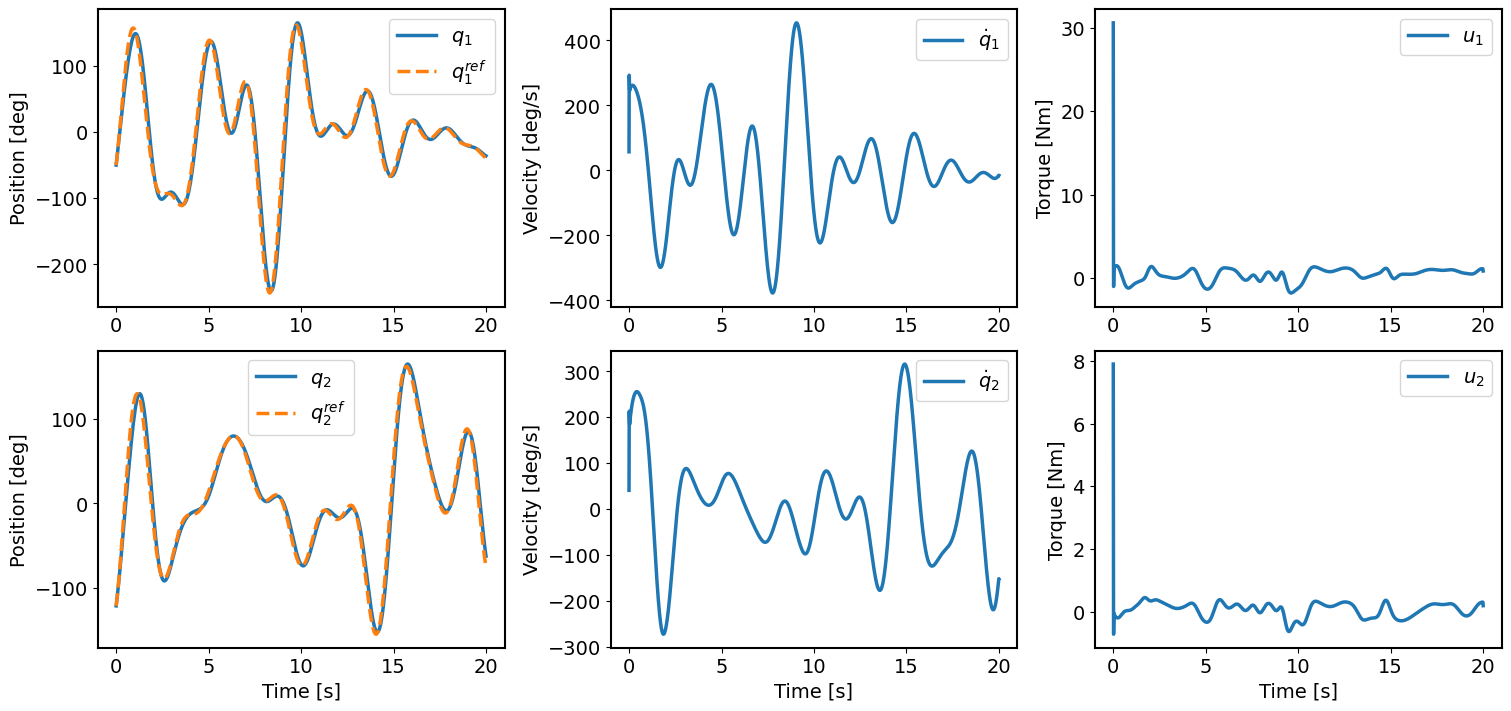

In [5]:
traj = 1
model = HAVOK()
RMSE = model.RMSE(X_true=torch.tensor(pendSim.ref[traj,:,:-1]),
                  X_pred=torch.tensor(pendSim.X[traj,:,:]))
print(RMSE)
plt.rcParams['font.size'] = 14 
fig, ax = plt.subplots(2, 3, constrained_layout = True, figsize=(15,7))

for i in range(2):

    ax[i,0].plot(pendSim.T[:-1], rad2deg(pendSim.X[traj,i,:]), label=r'$q_{%d}$'%(i+1))
    ax[i,0].plot(pendSim.T[:], rad2deg(pendSim.ref[traj,i,:]), label=r'$q_{%d}^{ref}$'%(i+1), linestyle='dashed')

    ax[i,1].plot(pendSim.T[:-1], rad2deg(pendSim.X[traj,2+i,:]), label=r'$\dot{q}_{%d}$'%(i+1))

    ax[i,2].plot(pendSim.T[:-1], pendSim.U[traj,i,:], label=r'$u_{%d}$'%(i+1))
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[1,0].set_xlabel('Time [s]'), ax[1,1].set_xlabel('Time [s]'), ax[1,2].set_xlabel('Time [s]')

## Model training 

In [6]:
nb_train, nb_test = 15000, 5000 # train-test ratio of 2

### Using *GPyOpt*

In [25]:
nb_train, nb_test, N_LQR = 15000, 5000, 20000 # train-test ratio of 2
traj_ratio = .05
n_low, n_high = 50, 250
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*nb_train)
d_low, d_high = 5, 20
ref_zeros = np.zeros([2,nb_train-1])

n_training = 1

domain = [
    {'name': 'dimension', 'type': 'discrete', 'domain': np.arange(5,80,1)},
    {'name': 'nb_traj', 'type': 'discrete', 'domain': np.arange(n_low,n_high,1)},
    {'name': 'nb_delays', 'type': 'discrete', 'domain': np.arange(d_low,d_high,1)}
#     {'name': 'u_std', 'type': 'discrete', 'domain': np.arange(4.,7.,1)}
]

print('delay max : ',np.int((1-traj_ratio)/n_high*nb_train))
print('points min : ',nb_train- d_high*n_high)

loss_prediction_train = np.empty(shape=[n_training])
loss_prediction_test = np.empty(shape=[n_training])
loss_prediction = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])
loss_LQR_U = np.empty(shape=[n_training])

def loss(space):
    # Model parameters
    n_params = space.shape[0] # If train by batch
    s = np.int(space[0,0])
    n = np.int(space[0,1])
    d = np.int(space[0,2])
#     u_std = space[0,3]
    
    timing = np.empty([2,n_training])
    
    for fold in range(n_training):
        timing[0,fold] = time.time() # HAVOK computation time
        
        # TRAINING #####################################################
        model = HAVOK(X=pendSim.X[fold,:,:nb_train], # state-wise difference
                      U=pendSim.U[fold,:,:nb_train],
                      mode='prediction',
                      nb_U=2,
                      nb_U_ex=0
                     )
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
        
#         model.ConstructLQR(x_std=1e6*np.array([1,1,0,0]),
#                    u_std=u_std,
#                    dt=pendSim.dt,
#                    horizon=N_LQR,
#                    ref=pendSim.ref[fold,:,:N_LQR],
#                    mode='LQR'
#                   )
        
        timing[0,fold] = time.time() - timing[0,fold]  
        timing[1,fold] = time.time() # Simulation time computation
        # TESTING ######################################################
        model.Simulate(X0=pendSim.X[fold,:,0],
                       horizon=nb_train,
                       U=pendSim.U[fold,:,:nb_train]
                      )
        
        loss_prediction_train[fold] = model.RMSE(X_pred=model.X_prediction,
                                           X_true=pendSim.X[fold,:,:nb_train]
                                                )
        model.Simulate(X0=pendSim.X[fold,:,nb_train],
                       horizon=nb_test,
                       U=pendSim.U[fold,:,nb_train:]
                      )
        loss_prediction_test[fold] = model.RMSE(X_pred=model.X_prediction[:,:-1],
                                                X_true=pendSim.X[fold,:,nb_train:]
                                               )
        
        model.Simulate(X0=pendSim.X[fold,:,0],
                       horizon=nb_test + nb_train,
                       U=pendSim.U[fold,:,:]
                      )
        loss_prediction[fold] = model.RMSE(X_pred=model.X_prediction[:,:-1],
                                           X_true=pendSim.X[fold,:,:]
                                           )
        
#         model.LQR_simulate(pendSim.X[fold,:,0].numpy(),
#                            mode='LQR'
#                           )
#         loss_LQR[fold] = model.RMSE(X_pred=model.LQR_X,
#                                     X_true=pendSim.ref[fold,:,:]
#                                    )
#         loss_LQR_U[fold] = model.RMSE(X_pred=model.LQR_U[0,:,:].T,
#                                       X_true=pendSim.U[fold,:,:]
#                                      )
        
        timing[1,fold] = time.time() - timing[1,fold]  
        
    loss_pred_train_sum = np.mean(loss_prediction_train)
    loss_pred_test_sum = np.mean(loss_prediction_test)
    loss_pred_sum = np.mean(loss_prediction)
#     loss_LQR_sum, loss_LQR_U_sum = np.mean(loss_LQR), np.mean(loss_LQR_U)
    loss = loss_pred_sum
#     loss = loss_pred_train_sum + loss_pred_test_sum
    avg_time = [timing[0,:].sum()/n_training,timing[1,:].sum()/n_training]
    
    if np.isnan(loss) or np.isinf(loss):
        loss = 1e10
        
#     print('Total loss : '+str(loss)+' Loss sim. : '+str(loss_traj_sum)+
#           ', s :'+str(s)+', n :'+str(n)+', d : '+str(d))
#     print('Total loss : '+str(loss)+' Loss train. : '+str(loss_pred_train_sum)+
#           ' Loss test. : '+str(loss_pred_test_sum)+' Loss LQR : '+str(loss_LQR_sum)+
#           ' Loss LQR_U: '+str(loss_LQR_U_sum)+', r :'+str(s)+', n :'+str(n)+', d : '+str(d)+', u_std : '+str(u_std))
    print('Total loss : '+str(loss)+' Loss train. : '+str(loss_pred_train_sum)+
          ' Loss test. : '+str(loss_pred_test_sum)+', r :'+str(s)+', n :'+str(n)+', d : '+str(d))
    print('Avg computation time for HAVOK : '+str(avg_time[0])+' [s], for sim. : '+str(avg_time[1])+' [s]')
    
    return loss

max_iter = 10000

opt = GPyOpt.methods.BayesianOptimization(f = loss,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.2)     # Exploration exploitation
 

opt.run_optimization(max_iter)

delay max :  57
points min :  10000
Total loss : 9.17099144034648e+17 Loss train. : 27509372485632.0 Loss test. : 38113.40625, r :16, n :169, d : 18
Avg computation time for HAVOK : 0.05227923393249512 [s], for sim. : 1.4311699867248535 [s]
Total loss : 5979.42236328125 Loss train. : 142.55633544921875 Loss test. : 446.99078369140625, r :66, n :186, d : 18
Avg computation time for HAVOK : 0.12865662574768066 [s], for sim. : 1.5174508094787598 [s]
Total loss : 12185375.0 Loss train. : 133731.375 Loss test. : 423.529541015625, r :45, n :132, d : 16
Avg computation time for HAVOK : 0.0857706069946289 [s], for sim. : 1.432168960571289 [s]
Total loss : 123.0302734375 Loss train. : 69.7394027709961 Loss test. : 427.6477355957031, r :68, n :112, d : 16
Avg computation time for HAVOK : 0.10571575164794922 [s], for sim. : 1.5957286357879639 [s]
Total loss : 197.44508361816406 Loss train. : 175.1739501953125 Loss test. : 367.0003356933594, r :33, n :62, d : 8
Avg computation time for HAVOK : 0.0

KeyboardInterrupt: 

## LQR control of the Panda robot
### Model prediction capabilities in training

87.5786


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

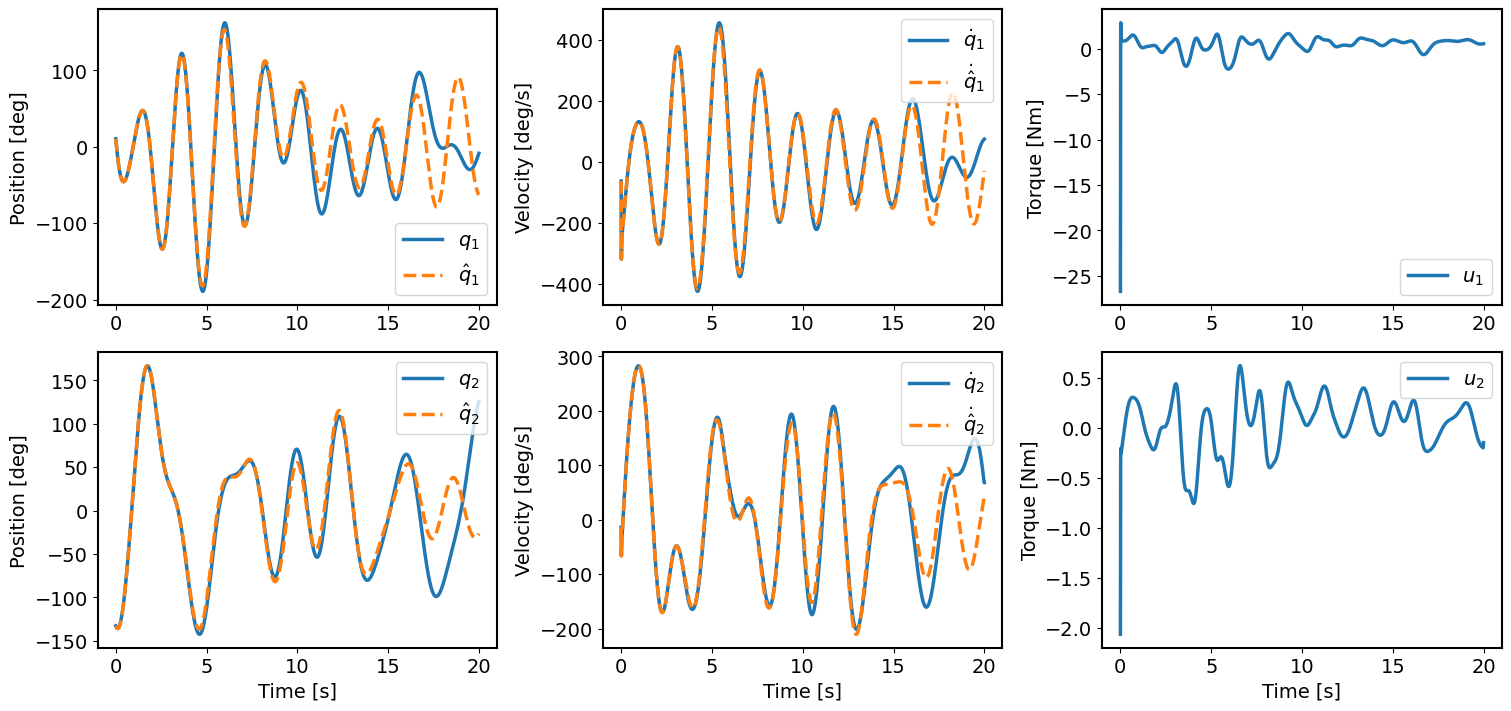

In [37]:
# Train linear model
traj = 0

n = 153
r = 88
d = 18

model = HAVOK(X=pendSim.X[traj,:,:nb_train], # state-wise difference
              U=pendSim.U[traj,:,:nb_train], # model predicted states
              mode='prediction',
              nb_U=2,
              nb_U_ex=0
             )

model.HANKEL(n, d)
model.SVD(r)
model.LS(r,rcond=0)

traj=0
model.Simulate(pendSim.X[traj,:,0],
               horizon=nb_test + nb_train-1,
               U=pendSim.U[traj,:,:],
               )
loss_traj = model.RMSE(X_true=pendSim.X[traj],
                       X_pred=model.X_prediction 
                      )
model.toNumpy()
print(loss_traj)

plt.rcParams['font.size'] = 14 
fig, ax = plt.subplots(2, 3, constrained_layout = True, figsize=(15,7))

for i in range(2):

    ax[i,0].plot(pendSim.T[:-1], rad2deg(pendSim.X[traj,i,:]), label=r'$q_{%d}$'%(i+1))
    ax[i,0].plot(pendSim.T[:-1], rad2deg(model.X_prediction[i,:]), label=r'$\hat{q}_{%d}$'%(i+1),linestyle='dashed')
    ax[i,1].plot(pendSim.T[:-1], rad2deg(pendSim.X[traj,2+i,:]), label=r'$\dot{q}_{%d}$'%(i+1))
    ax[i,1].plot(pendSim.T[:-1], rad2deg(model.X_prediction[2+i,:]), label=r'$\dot{\hat{q}}_{%d}$'%(i+1),linestyle='dashed')

    ax[i,2].plot(pendSim.T[:-1], pendSim.U[traj,i,:], label=r'$u_{%d}$'%(i+1))
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[1,0].set_xlabel('Time [s]'), ax[1,1].set_xlabel('Time [s]'), ax[1,2].set_xlabel('Time [s]')

### Train model and use LQR to correct trajectory

55.22356518648095
102.2085918330542


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

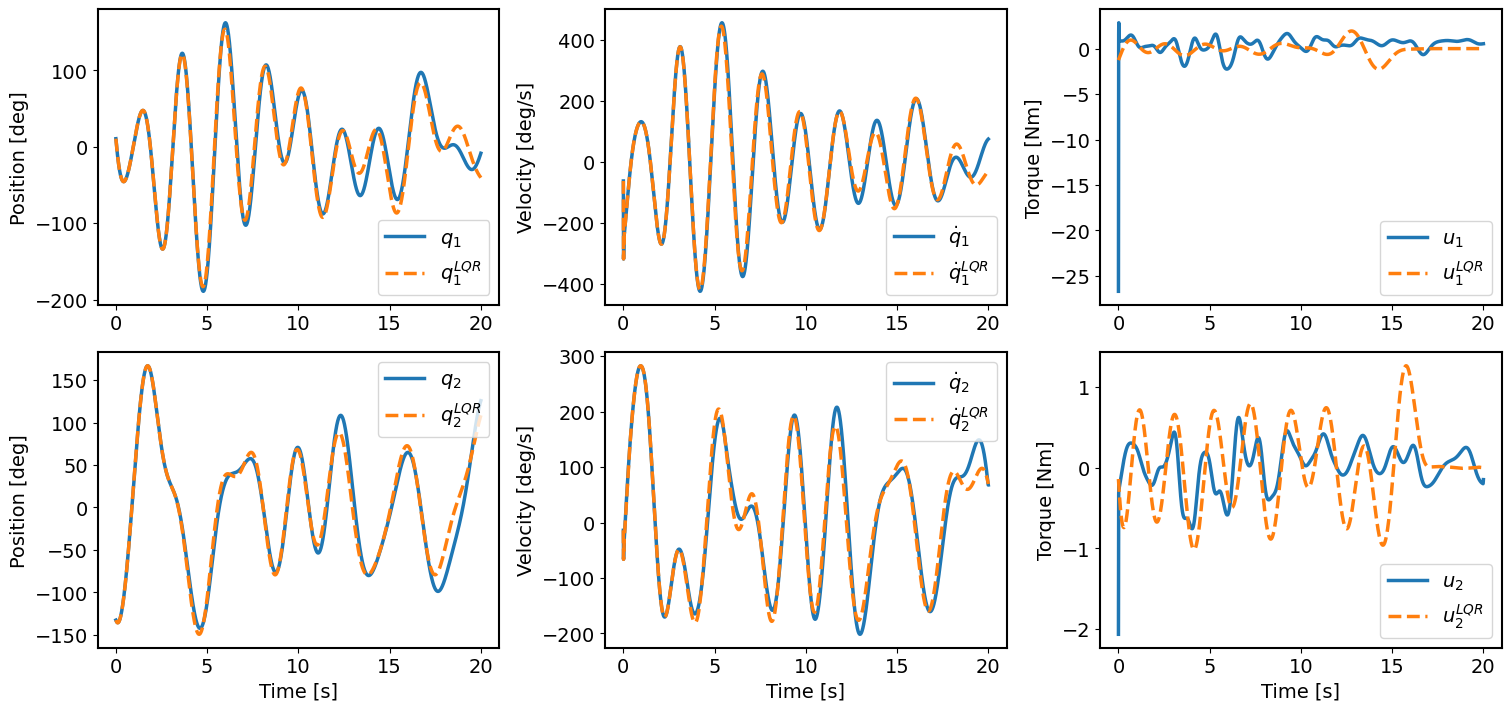

In [42]:
# Train linear model #######################################
traj = 0
# n = 122
# r = 68
# d = 17

# model = HAVOK(X=pendSim.X[traj,:,:nb_train], # state-wise difference
#               U=pendSim.U[traj,:,:nb_train], # model predicted states
#               mode='prediction',
#               nb_U=2,
#               nb_U_ex=0
#              )

# model.HANKEL(n, d)
# model.SVD(r)
# model.LS(r,rcond=0)

N_LQR = 20000
# Correct trajectories with ELQR ############################
model.ConstructLQR(x_std=1e6*np.array([1,1,0,0]),
                   u_std=5.,
                   dt=pendSim.dt,
                   horizon=N_LQR,
                   ref=pendSim.ref[traj,:,:N_LQR],
                   mode='LQR'
                  )
model.LQR_simulate(pendSim.X[traj,:,0].numpy(),
                   mode='LQR'
                  )

loss_LQR = model.RMSE(X_pred=model.LQR_X[:,:N_LQR-1],
                      X_true=pendSim.X[traj,:,:N_LQR-1]
                     )
loss_LQR_U = model.RMSE(X_pred=model.LQR_U[0,:,:N_LQR-1].T,
                        X_true=pendSim.U[traj,:,:N_LQR-1]
                       )
print(loss_LQR)
print(loss_LQR_U)

plt.rcParams['font.size'] = 14 
fig, ax = plt.subplots(2, 3, constrained_layout = True, figsize=(15,7))

for i in range(2):

    ax[i,0].plot(pendSim.T[:N_LQR-1], rad2deg(pendSim.X[traj,i,:N_LQR-1]), label=r'$q_{%d}$'%(i+1))
    ax[i,0].plot(pendSim.T[:N_LQR], rad2deg(model.LQR_X[i,:]), label=r'$q_{%d}^{LQR}$'%(i+1),linestyle='dashed')
    ax[i,1].plot(pendSim.T[:N_LQR-1], rad2deg(pendSim.X[traj,2+i,:N_LQR-1]), label=r'$\dot{q}_{%d}$'%(i+1))
    ax[i,1].plot(pendSim.T[:N_LQR], rad2deg(model.LQR_X[2+i,:]), label=r'$\dot{q}_{%d}^{LQR}$'%(i+1),linestyle='dashed')

    ax[i,2].plot(pendSim.T[:N_LQR-1], pendSim.U[traj,i,:N_LQR-1], label=r'$u_{%d}$'%(i+1))
    ax[i,2].plot(pendSim.T[:N_LQR-1], model.LQR_U[0,:,i], label=r'$u_{%d}^{LQR}$'%(i+1),linestyle='dashed')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[1,0].set_xlabel('Time [s]'), ax[1,1].set_xlabel('Time [s]'), ax[1,2].set_xlabel('Time [s]')

In [10]:
a= np.array([[1,2],[3,4]])
print(a)
print(a.T.reshape(4,1))

[[1 2]
 [3 4]]
[[1]
 [3]
 [2]
 [4]]


### Corrected trajectories

43513.52411816629


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

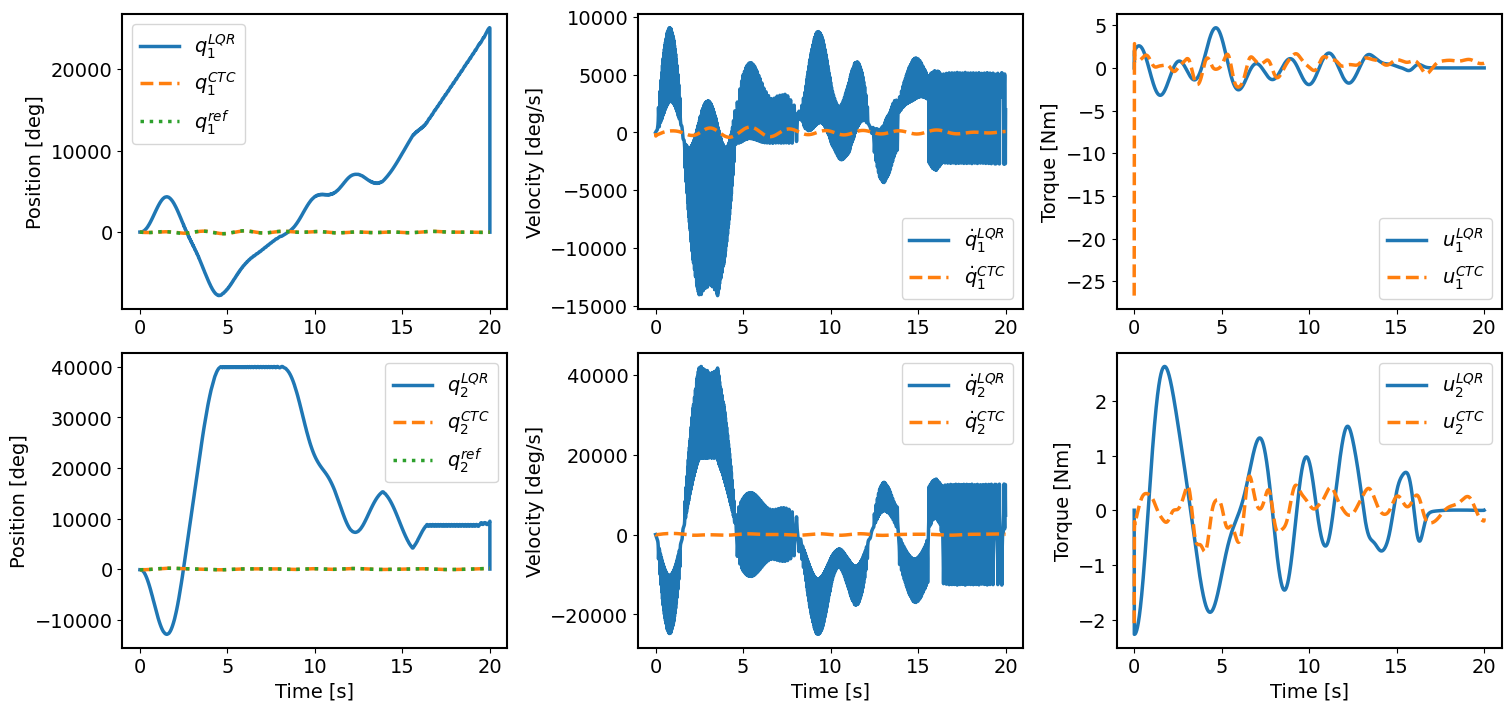

In [51]:
N = N_LQR
log_control = np.zeros(shape=[2,N-1])
log_control_model = np.zeros(shape=[2,N-1])
log_q = np.zeros(shape=[2,N])
log_dq = np.zeros(shape=[2,N])
log_ddq = np.zeros(shape=[2,N])
param = {'m1': .1, 'm2': .1, 
         'l1': .5, 'l2': .5,
         'time': np.arange(0,N*dt,dt), 'dt': dt
        }
pendulum = DoublePendulum(param)

torque_limit = np.array([100,100])
pendulum.x = np.array([[pendSim.ref[traj,0,0],0,0],
                       [pendSim.ref[traj,1,0],0,0]]
                     )

K = (np.array(model.LQR.K)[:,:,:] @ model.pinvC)

log_q[:,0] = pendulum.x[:,0]
log_dq[:,0] = pendulum.x[:,1]
log_ddq[:,0] = pendulum.x[:,2]

# Initialize matrices
pendulum.Physics(pendulum.x[:,:2])

for i in range(N_LQR-1):

    # Computed Torque Control for double pendulum
#     control_input = pendSim.U[traj,:,i].numpy()
#     control_input = model.LQR_U[0,i,:]
    control_input = -K[i,:] @ (pendSim.ref[traj,:,i] - np.concatenate((log_q[:,i],log_dq[:,i]),axis=0))

    for j in range(2):
        if control_input[j] > torque_limit[j]:
            control_input[j] = torque_limit[j]
        elif control_input[j] < -torque_limit[j]:
            control_input[j] = -torque_limit[j]

    pendulum.x[:,:2] = RK4(pendulum.Physics,
                           pendulum.x[:,:2],  
                           control_input,
                           pendulum.dt, 
                           type='controller-step-by-step'
                          ) # Simulation with Runge-Kutta 4
    pendulum.Physics(pendulum.x[:,:2],control_input)

    log_q[:,i] = pendulum.x[:,0]
    log_dq[:,i] = pendulum.x[:,1]
    log_control[:,i] = control_input

Xc = np.concatenate((log_q,log_dq),axis=0)
print(model.RMSE(X_true=pendSim.X[traj,:,:N-1],
                 X_pred=Xc[:,:-1]
                ))

plt.rcParams['font.size'] = 14 
fig, ax = plt.subplots(2, 3, constrained_layout = True, figsize=(15,7))

for i in range(2):

    ax[i,0].plot(pendSim.T[:N_LQR], rad2deg(Xc[i,:]), label=r'$q_{%d}^{LQR}$'%(i+1))
    ax[i,0].plot(pendReal.T[:N_LQR-1], rad2deg(pendSim.X[traj,i,:N_LQR-1]), label=r'$q_{%d}^{CTC}$'%(i+1), linestyle='dashed')
    ax[i,0].plot(pendSim.T[:N_LQR-1], rad2deg(pendSim.ref[traj,i,:N_LQR-1]), label=r'$q_{%d}^{ref}$'%(i+1), linestyle='dotted')

    ax[i,1].plot(pendSim.T[:N_LQR-1], rad2deg(Xc[2+i,:N_LQR-1]), label=r'$\dot{q}_{%d}^{LQR}$'%(i+1))
    ax[i,1].plot(pendReal.T[:N_LQR-1], rad2deg(pendSim.X[traj,2+i,:N_LQR-1]), label=r'$\dot{q}_{%d}^{CTC}$'%(i+1), linestyle='dashed')

    ax[i,2].plot(pendSim.T[:N_LQR-1], log_control[i,:N_LQR-1], label=r'$u_{%d}^{LQR}$'%(i+1))
    ax[i,2].plot(pendReal.T[:N_LQR-1], pendSim.U[traj,i,:N_LQR-1], label=r'$u_{%d}^{CTC}$'%(i+1), linestyle='dashed')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[1,0].set_xlabel('Time [s]'), ax[1,1].set_xlabel('Time [s]'), ax[1,2].set_xlabel('Time [s]')